In [90]:
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

import sklearn.metrics as metrics
import matplotlib.pyplot as plt

LISTINGSFILE = 'listings.csv'

cols = ['bedrooms', 'beds', 'price', 'accommodates', 'room_type']

df = pd.read_csv(LISTINGSFILE, usecols=cols)

len(df.index)

59945

Remove dollar character and change strings into floats.

In [91]:
df['price'] = df['price'].replace('[\$,)]','',  \
        regex=True).replace('[(]','-', regex=True).astype(float)

df.head(5)

,room_type,accommodates,bedrooms,beds,price
0,Entire home/apt,2,1.0,1.0,59.0
1,Entire home/apt,2,0.0,1.0,93.0
2,Entire home/apt,4,2.0,2.0,110.0
3,Entire home/apt,3,1.0,1.0,90.0
4,Entire home/apt,12,4.0,7.0,371.0


In [4]:
df.isnull().sum()

room_type        0
accommodates     0
bedrooms        91
beds            56
price            0
dtype: int64

Drop null values.

In [92]:
df = df.dropna()

In [69]:
len(df.index)

59812

Some information of the dataframe.

In [70]:
df.describe()

,accommodates,bedrooms,beds,price
count,59812.000000,59812.000000,59812.000000,59812.000000
mean,3.059052,1.076590,1.708503,100.206798
std,1.527024,0.981906,1.125033,119.254950
min,1.000000,0.000000,0.000000,0.000000
25%,2.000000,1.000000,1.000000,55.000000
50%,2.000000,1.000000,1.000000,75.000000
75%,4.000000,1.000000,2.000000,110.000000
max,16.000000,50.000000,50.000000,9379.000000


Check what sort of values are there. This was obviously done for each column, but only keeping one here to lessen the number of rows this document is getting.

In [37]:
df['bedrooms'].value_counts()

1.0     34226
0.0     12863
2.0      9316
3.0      2606
4.0       646
5.0       118
6.0        20
7.0         9
50.0        7
10.0        1
Name: bedrooms, dtype: int64

Take out some of the massive buildings.

In [93]:
df = df[df['beds'] <= 10]
#df = df[df['beds'] > 0]
df = df[df['bedrooms'] <= 10]
#df = df[df['bedrooms'] > 0]
df = df[df['accommodates'] <= 10]
#df = df[df['accommodates'] > 0]
df = df[df['price'] <= 400]
#df = df[df['price'] > 0]
len(df.index)

58868

In [72]:
df.describe()

,accommodates,bedrooms,beds,price
count,58868.000000,58868.000000,58868.000000,58868.000000
mean,2.997979,1.041924,1.666117,91.135812
std,1.397033,0.784320,0.958306,58.549111
min,1.000000,0.000000,0.000000,0.000000
25%,2.000000,1.000000,1.000000,55.000000
50%,2.000000,1.000000,1.000000,75.000000
75%,4.000000,1.000000,2.000000,105.000000
max,10.000000,7.000000,10.000000,400.000000


Generate dummies for 'room_type' column and use imputer to generate new values where the original values is '0'. We are using the 'mean' strategy here. It means that the missing values is replaces by the 'mean' value of the column.

In [94]:
# get feature encoding for categorical variables
rt_dummies = pd.get_dummies(df.room_type)

In [95]:
from sklearn import preprocessing
imputer = preprocessing.Imputer(missing_values=0, strategy='mean', axis=0)
temp_df = df.drop('room_type', axis=1)
imputer = imputer.fit(temp_df)

df_imputed = pd.DataFrame(imputer.transform(temp_df.values))
df_imputed.columns = temp_df.columns
df_imputed.index = temp_df.index

finaldata = pd.concat((df_imputed, rt_dummies.astype(int)), axis=1)

Round the numbers to get rid of the floats that were generated by the imputer previously, but also perhaps to reduce the skewing of the data. However, there are not rooms with 1.5 beds so even for that reason it's good idea to round them.

In [96]:
finaldata.bedrooms = finaldata.bedrooms.round()
finaldata.beds = finaldata.beds.round()
finaldata.accommodates = finaldata.accommodates.round()

In [76]:
finaldata.head()

,accommodates,bedrooms,beds,price,Entire home/apt,Private room,Shared room
0,2.0,1.0,1.0,59.0,1,0,0
1,2.0,1.0,1.0,93.0,1,0,0
2,4.0,2.0,2.0,110.0,1,0,0
3,3.0,1.0,1.0,90.0,1,0,0
5,2.0,1.0,1.0,70.0,1,0,0


Visualize the data element occurances to see how the data is divided.

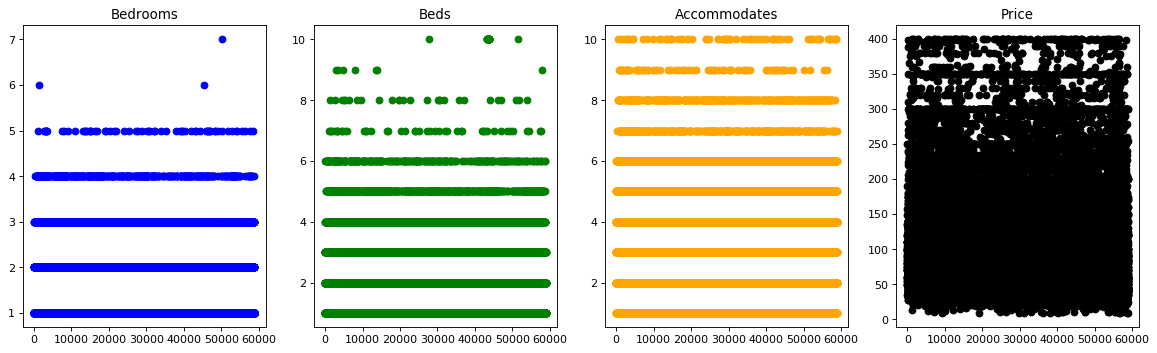

In [97]:
import matplotlib.ticker as ticker
N = len(finaldata['beds'])
x = range(N)
fig = plt.figure(figsize=(18, 5), dpi= 80, facecolor='w', edgecolor='k')

plt.subplot(1, 4, 1)
plt.gca().set_title('Bedrooms')
plt.scatter(x, finaldata['bedrooms'], c="blue")

plt.subplot(1, 4, 2)
plt.gca().set_title('Beds')
plt.scatter(x, finaldata['beds'], c="green")

plt.subplot(1, 4, 3)
plt.gca().set_title('Accommodates')
plt.scatter(x, finaldata['accommodates'], c="orange")

plt.subplot(1, 4, 4)
plt.gca().set_title('Price')
plt.scatter(x, finaldata['price'], c="black")

plt.show()

Histograms to see distribution even better.

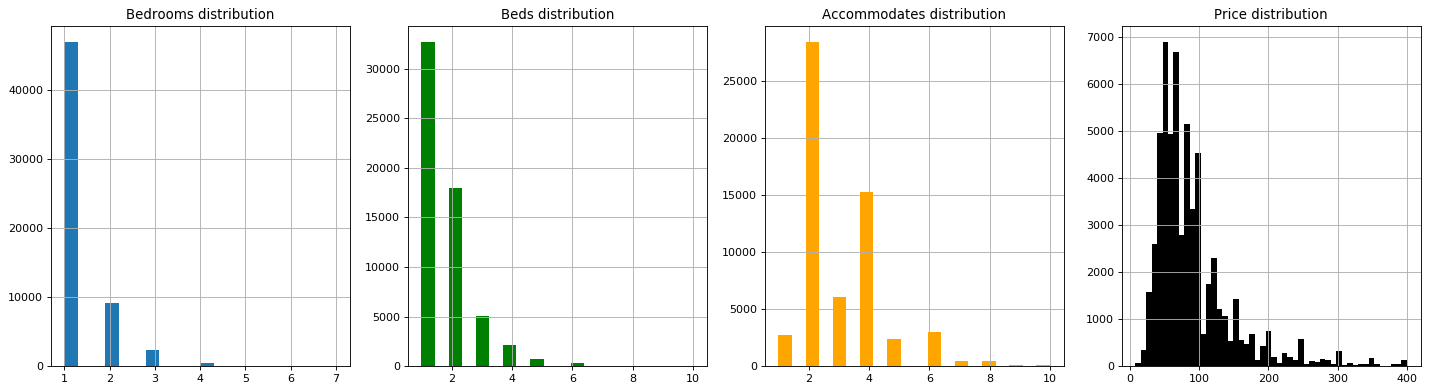

In [98]:
fig = plt.figure(figsize=(18, 5), dpi= 80, facecolor='w', edgecolor='k')

plt.subplot(1, 4, 1)
plt.gca().set_title('Bedrooms distribution')
finaldata['bedrooms'].hist(bins=20)
fig.tight_layout()

plt.subplot(1, 4, 2)
plt.gca().set_title('Beds distribution')
finaldata['beds'].hist(bins=20, color='green')
fig.tight_layout()

plt.subplot(1, 4, 3)
plt.gca().set_title('Accommodates distribution')
finaldata['accommodates'].hist(bins=20, color='orange')
fig.tight_layout()

plt.subplot(1, 4, 4)
plt.gca().set_title('Price distribution')
finaldata['price'].hist(bins=50, color='black')
fig.tight_layout()
plt.show()


From the correlation table we can notice that 'accommodates', 'bedrooms' and 'beds' somewhat good positive effect on the 'price'. However, room types do not seem to have much correlation to 'price'.

In [99]:
finaldata.describe()

,accommodates,bedrooms,beds,price,Entire home/apt,Private room,Shared room
count,58868.000000,58868.000000,58868.000000,58868.000000,58868.000000,58868.000000,58868.000000
mean,2.997979,1.260260,1.666559,91.168335,0.868893,0.122443,0.008663
std,1.397033,0.575187,0.957999,58.523794,0.337520,0.327800,0.092674
min,1.000000,1.000000,1.000000,8.000000,0.000000,0.000000,0.000000
25%,2.000000,1.000000,1.000000,55.000000,1.000000,0.000000,0.000000
50%,2.000000,1.000000,1.000000,75.000000,1.000000,0.000000,0.000000
75%,4.000000,1.000000,2.000000,105.000000,1.000000,0.000000,0.000000
max,10.000000,7.000000,10.000000,400.000000,1.000000,1.000000,1.000000


In [100]:
finaldata.corr()

,accommodates,bedrooms,beds,price,Entire home/apt,Private room,Shared room
accommodates,1.000000,0.678901,0.800486,0.580993,0.282930,-0.269287,-0.077934
bedrooms,0.678901,1.000000,0.708123,0.567381,0.151352,-0.143881,-0.042300
beds,0.800486,0.708123,1.000000,0.525634,0.175972,-0.186873,0.020101
price,0.580993,0.567381,0.525634,1.000000,0.217151,-0.200114,-0.083037
Entire home/apt,0.282930,0.151352,0.175972,0.217151,1.000000,-0.961614,-0.240661
Private room,-0.269287,-0.143881,-0.186873,-0.200114,-0.961614,1.000000,-0.034919
Shared room,-0.077934,-0.042300,0.020101,-0.083037,-0.240661,-0.034919,1.000000


Correlation table without room types.

In [101]:
df_wo_rt = finaldata.drop(['Entire home/apt', 'Private room', 'Shared room'], axis=1)
df_wo_rt.corr()

,accommodates,bedrooms,beds,price
accommodates,1.000000,0.678901,0.800486,0.580993
bedrooms,0.678901,1.000000,0.708123,0.567381
beds,0.800486,0.708123,1.000000,0.525634
price,0.580993,0.567381,0.525634,1.000000


Also in the form of a heatmap. Aleksiro used it on his own report and I decided to use it myself as well because it shows the correlations quite nicely.

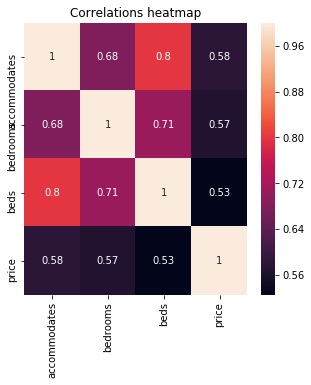

In [102]:
import seaborn as sns
plt.figure(figsize=(5,5))
sns.heatmap(df_wo_rt.corr(),annot=True)
plt.title('Correlations heatmap')
plt.show()

New dataframes for visualization.

In [103]:
bed_counts = df_wo_rt['beds'].value_counts().rename_axis('unique_values').reset_index(name='counts')
room_counts = df_wo_rt['bedrooms'].value_counts().rename_axis('unique_values').reset_index(name='counts')
acc_counts = df_wo_rt['accommodates'].value_counts().rename_axis('unique_values').reset_index(name='counts')
acc_counts.head()

,unique_values,counts
0,2.0,28401
1,4.0,15273
2,3.0,6072
3,6.0,2972
4,1.0,2756


In [104]:
df_testi = df_wo_rt.copy()
# The mean price of each unique value.
bed_price_mean = df_testi.groupby(['beds']).agg(np.mean)['price'].rename_axis('unique_values').reset_index(name='price')
room_price_mean = df_testi.groupby(['bedrooms']).agg(np.mean)['price'].rename_axis('unique_values').reset_index(name='price')
acc_price_mean = df_testi.groupby(['accommodates']).agg(np.mean)['price'].rename_axis('unique_values').reset_index(name='price')

bed_price_mean.head()

,unique_values,price
0,1.0,70.050606
1,2.0,97.868303
2,3.0,146.601096
3,4.0,170.374525
4,5.0,206.066282


Make another dataframe with also price column rounded. Also all values are converted to type int. Reason being to see how it affects the prediction results.

In [105]:
comp_df = df_wo_rt.copy()

In [106]:
comp_df.price = comp_df.price.round()
comp_df = comp_df.astype(int)
comp_df.head()

,accommodates,bedrooms,beds,price
0,2,1,1,59
1,2,1,1,93
2,4,2,2,110
3,3,1,1,90
5,2,1,1,70


Visualization to show the occurance counts of each value for beds, bedrooms and accommodates. 

In [107]:
import plotly

import plotly.plotly as py
from plotly.graph_objs import *

trace_acc = Bar(x=acc_counts['unique_values'],
                  y=acc_counts['counts'],
                  name='Accommodates',
                  marker=dict(color='#ffcdd2'),
                  width=0.2)

trace_beds = Bar(x=bed_counts['unique_values'],
                y=bed_counts['counts'],
                name='Beds',
                marker=dict(color='#A2D5F2'),
                  width=0.2)

trace_rooms = Bar(x=room_counts['unique_values'],
                y=room_counts['counts'],
                name='Bedrooms',
                marker=dict(color='#59606D'),
                  width=0.2)

data = [trace_acc, trace_beds, trace_rooms]
layout = Layout(title="Occurance counts of Beds, Bedrooms and Accommodates in the data.",
                xaxis=dict(title='Unique values'),
                yaxis=dict(title='Frequency'))
fig = Figure(data=data, layout=layout)

py.iplot(fig, filename='count_bar')

Visualization of the mean price of each beds, bedroom and accommodate value.

In [108]:
mean_acc = Bar(x=acc_price_mean['unique_values'],
                y=acc_price_mean['price'],
                name='Accommodates',
                marker=dict(color='#ffcdd2'),
                width=0.2)

mean_beds = Bar(x=bed_price_mean['unique_values'],
                 y=bed_price_mean['price'],
                 name='Beds',
                 marker=dict(color='#A2D5F2'),
                 width=0.2)

mean_rooms = Bar(x=room_price_mean['unique_values'],
                  y=room_price_mean['price'],
                  name='Bedrooms',
                  marker=dict(color='#59606D'),
                  width=0.2)

data = [mean_acc, mean_beds, mean_rooms]
layout = Layout(title="Mean price value for each unique value occurance.",
                xaxis=dict(title='Mean price'),
                yaxis=dict(title='Unique values'))
fig = Figure(data=data, layout=layout)

py.iplot(fig, filename='mean_price_bar')

Comparing prediction models. Taken from the example: https://mapr.com/blog/predicting-airbnb-listing-prices-scikit-learn-and-apache-spark/.
All of them are pretty close at around 22-23 dollars.

Text(0,0.5,'Median Absolute Error')

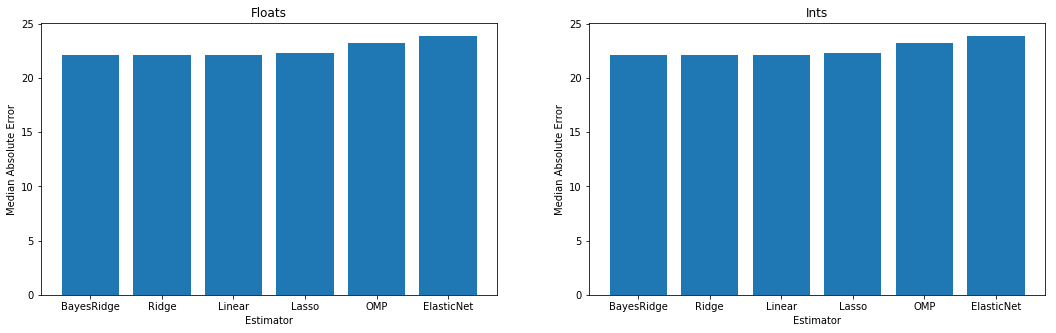

In [109]:
from sklearn import linear_model

rs = 1
ests = [ linear_model.LinearRegression(), linear_model.Ridge(),
        linear_model.Lasso(), linear_model.ElasticNet(),
        linear_model.BayesianRidge(), linear_model.OrthogonalMatchingPursuit() ]
ests_labels = np.array(['Linear', 'Ridge', 'Lasso', 'ElasticNet', 'BayesRidge', 'OMP'])
errvals = np.array([])
errvals2 = np.array([])

X_train, X_test, y_train, y_test = train_test_split(df_wo_rt.drop(['price'], axis=1),
                                                    df_wo_rt.price, test_size=0.2, random_state=20)
X2_train, X2_test, y2_train, y2_test = train_test_split(comp_df.drop(['price'], axis=1),
                                                    comp_df.price, test_size=0.2, random_state=20)

for e in ests:
    e.fit(X_train, y_train)
    this_err = metrics.median_absolute_error(y_test, e.predict(X_test))
    #print "got error %0.2f" % this_err
    errvals = np.append(errvals, this_err)
    
for k in ests:
    k.fit(X2_train, y2_train)
    this_err2 = metrics.median_absolute_error(y2_test, k.predict(X2_test))
    #print "got error %0.2f" % this_err
    errvals2 = np.append(errvals2, this_err2)
    
pos = np.arange(errvals.shape[0])
srt = np.argsort(errvals)
pos2 = np.arange(errvals2.shape[0])
srt2 = np.argsort(errvals2)

plt.figure(figsize=(18,5))

plt.subplot(1, 2, 1)
plt.gca().set_title('Floats')
plt.bar(pos, errvals[srt], align='center')
plt.xticks(pos, ests_labels[srt])
plt.xlabel('Estimator')
plt.ylabel('Median Absolute Error')

plt.subplot(1, 2, 2)
plt.gca().set_title('Ints')
plt.bar(pos2, errvals2[srt2], align='center')
plt.xticks(pos2, ests_labels[srt2])
plt.xlabel('Estimator')
plt.ylabel('Median Absolute Error')

Scatter matrix to see if there are anything wrong with the data. Sadly doesn't show any big correlations.

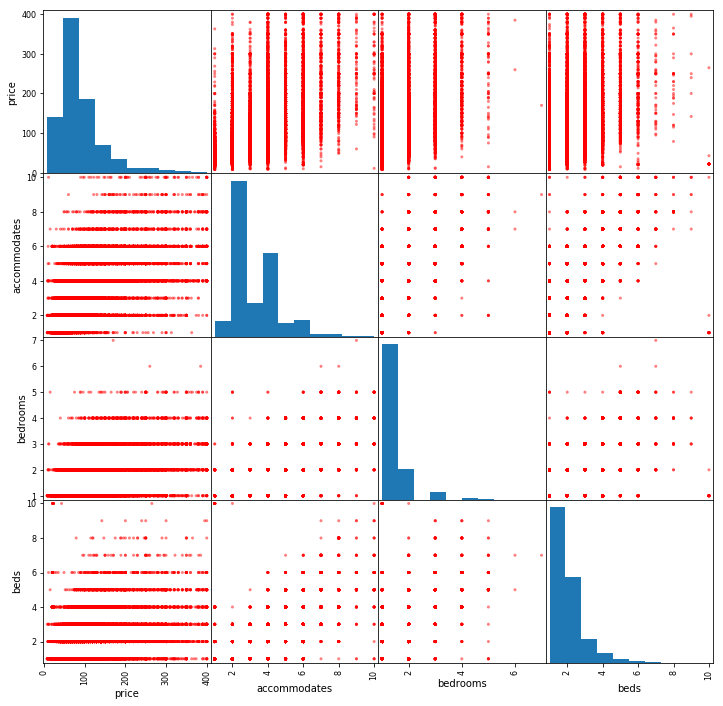

In [110]:
from pandas.plotting import scatter_matrix
scattercols = ['price','accommodates', 'bedrooms', 'beds']
axs = scatter_matrix(df_wo_rt[scattercols],
                        figsize=(12, 12), c='red')

Feature importance with RandomForestClassifier: http://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html#sphx-glr-auto-examples-ensemble-plot-forest-importances-py. Shows that features are quite informative in prediction.

Feature ranking:
1. feature 0 (0.396595)
2. feature 1 (0.302538)
3. feature 2 (0.300867)


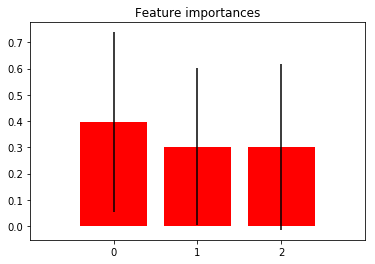

In [111]:
from sklearn.ensemble import RandomForestClassifier

#X2_train, X2_test, y2_train, y2_test

clf = RandomForestClassifier(n_estimators=200, max_depth=2, random_state=0)
clf.fit(X2_train, y2_train)
#clf.feature_importances_

importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X2_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X2_train.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X2_train.shape[1]), indices)
plt.xlim([-1, X2_train.shape[1]])
plt.show()

Machine Learning phase. Here we are trying to use Lasso as our model and predict with cross_val_predict. Early the correlations weren't very high at around 50-60% so the prediction doesn't really fit the line too well.

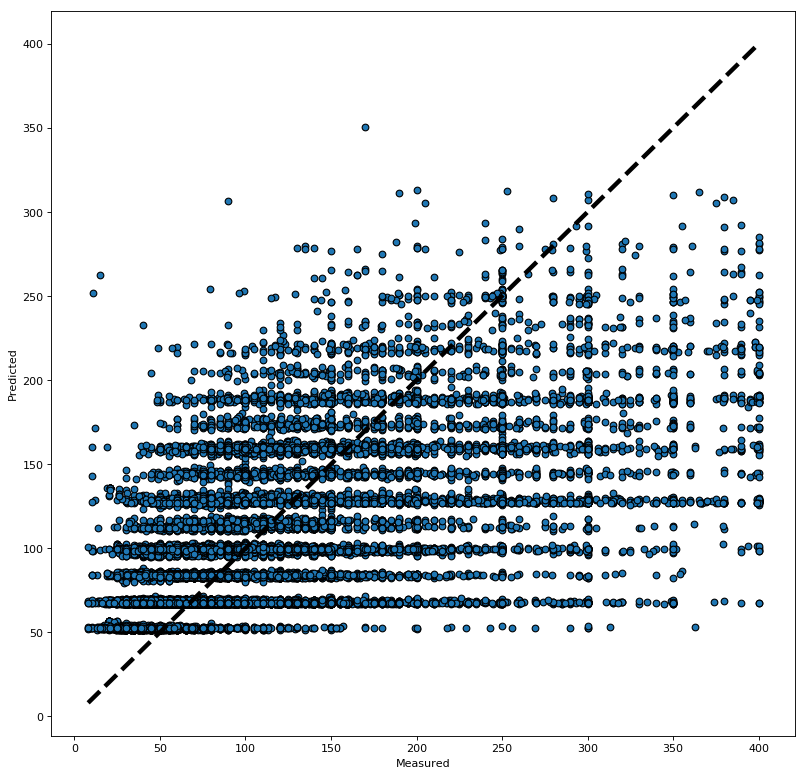

In [112]:
from sklearn.model_selection import cross_val_predict
df_wo_rt_train = df_wo_rt.drop(columns='price')
df_wo_rt_labels = df_wo_rt.price

la = linear_model.Lasso()
predict = cross_val_predict(la, df_wo_rt_train, df_wo_rt_labels, cv=10)
#fig, ax = plt.subplots()
fig = plt.figure(figsize=(12, 12), dpi= 80, facecolor='w', edgecolor='k')
plt.plot([df_wo_rt_labels.min(), df_wo_rt_labels.max()], [df_wo_rt_labels.min(), df_wo_rt_labels.max()], 'k--', lw=4)
#ax.scatter(df_wo_rt_labels, predict, edgecolors=(0, 0, 0))
plt.scatter(df_wo_rt_labels, predict, edgecolors=(0, 0, 0))

plt.xlabel('Measured')
plt.ylabel('Predicted')
plt.show()

Using the example at https://mapr.com/blog/predicting-airbnb-listing-prices-scikit-learn-and-apache-spark/ we try to improve the prediction. However, it doesn't get much better.

In [113]:
from sklearn import ensemble
from sklearn.grid_search import GridSearchCV

n_est = 300

tuned_parameters = {
    "n_estimators": [ n_est ],
    "max_depth" : [ 4 ],
    "learning_rate": [ 0.01 ],
    "min_samples_split" : [ 1.0 ],
    "loss" : [ 'ls', 'lad' ]
}

gbr = ensemble.GradientBoostingRegressor()
clf = GridSearchCV(gbr, cv=5, param_grid=tuned_parameters,
        scoring='neg_median_absolute_error')
preds = clf.fit(X_train, y_train)
best = clf.best_estimator_
best

/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning:

This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.

/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning:

This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.



GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.01, loss='lad', max_depth=4,
             max_features=None, max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=1.0,
             min_weight_fraction_leaf=0.0, n_estimators=300,
             presort='auto', random_state=None, subsample=1.0, verbose=0,
             warm_start=False)

Text(0,0.5,'Least Absolute Deviation')

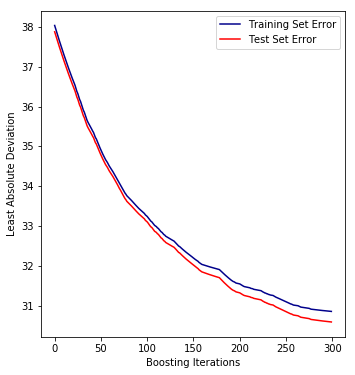

In [114]:
test_score = np.zeros(n_est, dtype=np.float64)

train_score = best.train_score_
for i, y_pred in enumerate(best.staged_predict(X_test)):
    test_score[i] = best.loss_(y_test, y_pred)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(np.arange(n_est), train_score, 'darkblue', label='Training Set Error')
plt.plot(np.arange(n_est), test_score, 'red', label='Test Set Error')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Least Absolute Deviation')

Again borrowing from the example article to see which features had the biggest effect. According to this we can see that the accommodates was the most important variable in predicting the price value.

Text(0.5,1,'Variable Importance')

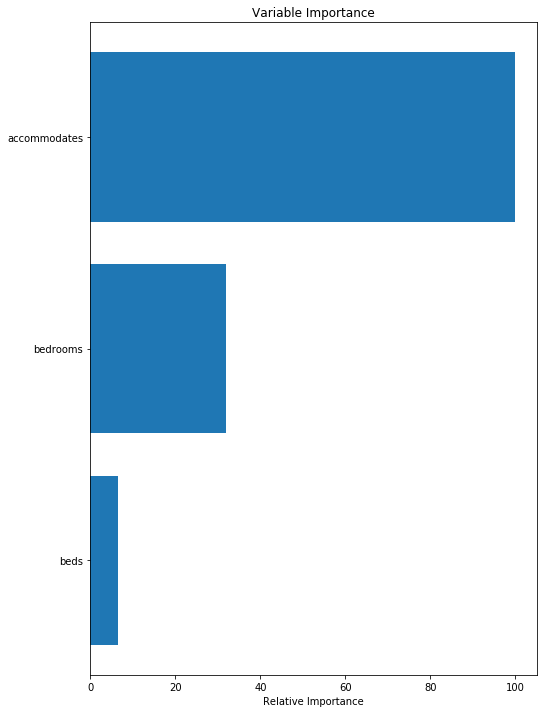

In [115]:
feature_importance = clf.best_estimator_.feature_importances_
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
pvals = feature_importance[sorted_idx]
pcols = X_train.columns[sorted_idx]
plt.figure(figsize=(8,12))
plt.barh(pos, pvals, align='center')
plt.yticks(pos, pcols)
plt.xlabel('Relative Importance')
plt.title('Variable Importance')

Finally some Kmeans clustering to see if any groups were possible to form from the data.

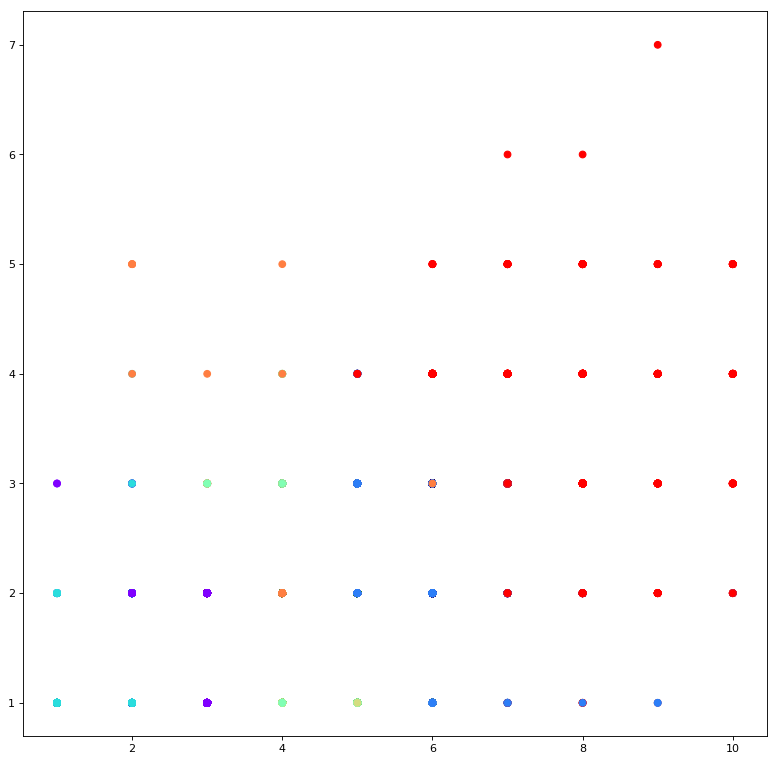

In [116]:
from sklearn.cluster import KMeans

df_train = df_wo_rt.drop('price', axis=1).iloc[:(len(df_wo_rt)-3000)]
df_test = df_wo_rt.drop('price', axis=1).iloc[(len(df_wo_rt)-3000):]
df_train_mat = df_train.as_matrix(columns=['accommodates', 'bedrooms', 'beds'])
df_test_mat = df_test.as_matrix(columns=['accommodates', 'bedrooms', 'beds'])
kmeans = KMeans(n_clusters=7)  
kmeans.fit(df_train_mat)

#labels = kmeans.labels_
# Format results as a DataFrame
predict = kmeans.predict(df_test_mat)
kmeans.cluster_centers_,
kmeans.labels_
plt.figure(figsize=(12, 12), dpi= 80, facecolor='w', edgecolor='k')
plt.scatter(df_train.iloc[:,0].values, df_train.iloc[:,1].values, c=kmeans.labels_, cmap='rainbow')

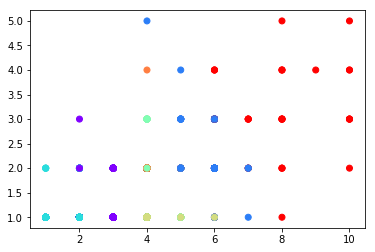

In [117]:
plt.scatter(df_test.iloc[:,0].values, df_test.iloc[:,1].values, c=predict, cmap='rainbow')

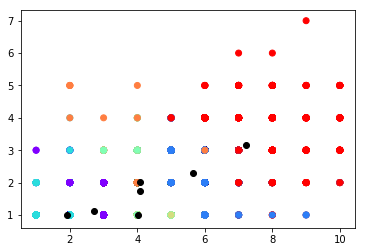

In [118]:
plt.scatter(df_train.iloc[:,0].values, df_train.iloc[:,1].values, c=kmeans.labels_, cmap='rainbow')  
plt.scatter(kmeans.cluster_centers_[:,0] ,kmeans.cluster_centers_[:,1], color='black')